<a href="https://colab.research.google.com/github/JCaballerot/Recommender-Systems/blob/main/Autoencoder_Recommender/Autoencoder_CF_Yelp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Autoencoder Collaborative Filtering Yelp**

## Contexto

Yelp es una plataforma en línea lanzada en 2004 que permite a los usuarios buscar, calificar y reseñar negocios locales. Incluye una amplia variedad de categorías como restaurantes, bares, salones de belleza, talleres mecánicos, hoteles, y más. Su objetivo principal es conectar a las personas con los mejores negocios en sus comunidades a través de información detallada y opiniones confiables.

El dataset de Yelp es un recurso ampliamente utilizado en investigación y aplicaciones relacionadas con sistemas de recomendación, análisis de texto, minería de datos y machine learning. Proporciona una colección rica de datos sobre negocios, usuarios y las interacciones entre ambos, extraídos de la plataforma Yelp.

**Tamaño y Escala**

El dataset es considerablemente grande y puede ocupar varios GB, dependiendo de la versión descargada. Por ejemplo:

- Reseñas: Más de 8 millones.
- Usuarios: Más de 1.5 millones.
- Negocios: Alrededor de 200,000.


## Objetivo

El objetivo de este laboratorio es desarrollar un sistema de recomendación utilizando un modelo de autoencoder. Este modelo es capaz de aprender representaciones comprimidas de datos para predecir calificaciones de usuarios a productos.

## Tabla de Contenidos

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>
    
1. <a href="#item31">Introducción y Configuración Inicial</a>  
2. <a href="#item32">Carga y Exploración de Datos</a>  
3. <a href="#item34">Análisis de Distribución de Datos</a>  
4. <a href="#item34">Construcción de la Matriz de Interacción</a>
5. <a href="#item34">Construcción del Modelo Autoencoder</a>
6. <a href="#item34">Entrenamiento del Modelo</a>
7. <a href="#item34">Evaluación del Desempeño del Modelo</a>



</font>
</div>




## 1. Introducción y Configuración Inicial

Comenzamos configurando el entorno para trabajar con los datasets de Kaggle. Esto incluye la instalación de la API de Kaggle y la descarga de datos.


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
%%capture
# Descargar el dataset de Last.fm desde Kaggle
!pip install kaggle

In [3]:

from google.colab import files
files.upload()  # Sube tu archivo kaggle.json aquí

# Configurar Kaggle API
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


# Descargar otro dataset de Yelp
!kaggle datasets download -d yelp-dataset/yelp-dataset

# Descomprimir el archivo descargado
!unzip yelp-dataset.zip


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/yelp-dataset/yelp-dataset
License(s): other
100% 4.07G/4.07G [01:43<00:00, 40.5MB/s]
100% 4.07G/4.07G [01:43<00:00, 42.1MB/s]
Archive:  yelp-dataset.zip
  inflating: Dataset_User_Agreement.pdf  
  inflating: yelp_academic_dataset_business.json  
  inflating: yelp_academic_dataset_checkin.json  
  inflating: yelp_academic_dataset_review.json  
  inflating: yelp_academic_dataset_tip.json  
  inflating: yelp_academic_dataset_user.json  


**Descripción de los archivos descargados:**

- **yelp_academic_dataset_review.json:** Contiene información sobre usuarios, negocios y calificaciones.
- **yelp_academic_dataset_business.json:** Detalla información sobre negocios.

## 2. Carga y Exploración de Datos

**Lectura del archivo de calificaciones**

Cargamos el dataset de reviews en un DataFrame y exploramos sus columnas principales.

In [2]:
import json
import pandas as pd

# Leer el archivo JSON
file_path = "yelp_academic_dataset_review.json"
ratings_data = []

with open(file_path, 'r') as file:
    for line in file:
        ratings_data.append(json.loads(line))  # Decodificar cada línea como JSON

# Convertir la lista de diccionarios en un DataFrame
ratings_df = pd.DataFrame(ratings_data)

# Mostrar las primeras filas del DataFrame
ratings_df[['user_id', 'business_id', 'stars']].head()


,user_id,business_id,stars
0,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0
1,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0
2,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0
3,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0
4,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0


**Lectura del archivo de negocios**

Cargamos la información de negocios para complementarla con los datos de calificaciones.

In [ ]:
# Leer el archivo JSON
file_path = "yelp_academic_dataset_business.json"
ratings_data = []

with open(file_path, 'r') as file:
    for line in file:
        ratings_data.append(json.loads(line))  # Decodificar cada línea como JSON

# Convertir la lista de diccionarios en un DataFrame
yelp_academic_dataset_business = pd.DataFrame(ratings_data)

# Mostrar las primeras filas del DataFrame
yelp_academic_dataset_business[['business_id', 'name']].head()


In [ ]:
ratings_df = ratings_df[['user_id', 'business_id', 'stars']]
ratings_df.head()

## 3. Análisis de Distribución de Datos

Analizamos la distribución del número de reviews por negocio para entender mejor la naturaleza de los datos.

In [184]:
business_id_counts = ratings_df.groupby('business_id').size().sort_values(ascending=False)


In [ ]:
# Visualizar distribución long tail
plt.figure(figsize=(12, 6))
plt.bar(range(len(business_id_counts)), business_id_counts, color='lightblue')
plt.title('Distribución del Número de reviews por negocio (Long Tail)')
plt.xlabel('Negocios ordenados por reviews')
plt.ylabel('Número de reviews')
plt.ylim(1, 1000)
plt.show()


**Filtrado de negocios y usuarios**

Seleccionamos solo negocios y usuarios con suficiente actividad para enfocarnos en datos relevantes.

In [185]:
# Filtrar artistas con al menos 500 reviews
min_reviews_per_business = 500
popular_business = business_id_counts[business_id_counts >= min_reviews_per_business].index
ratings_df_filtered = ratings_df[ratings_df['business_id'].isin(popular_business)]


In [186]:
len(popular_business.drop_duplicates())

1458

In [187]:
# Filtrar usuarios con al menos 100 escuchas
users_review_counts = ratings_df_filtered.groupby('user_id').size().sort_values(ascending=False)
users_review_counts

,0
user_id,
ET8n-r7glWYqZhuR6GcdNw,308
1HM81n6n4iPIFU5d2Lokhw,221
CfX4sTIFFNaRchNswqhVfg,215
E4BsVQnG5zetbwv2x8QIWg,204
_BcWyKQL16ndpBdggh2kNA,202
...,...
OiT7EPlRC6baiJL0yFZ8NQ,1
OiT-2vSyyekxWbPXipt-iA,1
OiSJHV7j32tPVuWqD2v-yQ,1


In [188]:
# Filtrar usuarios con al menos 500 reviews
min_reviews_per_user = 50
popular_users = users_review_counts[users_review_counts >= min_reviews_per_user].index
ratings_df_filtered = ratings_df_filtered[ratings_df_filtered['user_id'].isin(popular_users)]


In [126]:
len(popular_users)

2424

## 4. Construcción de la Matriz de Interacción

Generamos una matriz que relacione usuarios y negocios basada en las calificaciones promedio.

In [189]:
ratings_df_filtered = ratings_df_filtered.groupby(['business_id', 'user_id'], as_index=False).agg({'stars': 'mean'})
interaction_matrix = ratings_df_filtered.pivot(index='business_id', columns='user_id', values='stars').reset_index()
interaction_matrix.head()

user_id,business_id,-B-QEUESGWHPE_889WJaeg,-TLXQfY2lZ6DVWQj4BosxQ,-V7frksbFjKQYVhrPnnlPw,-ZHlPAvlVdgtiu6DiCq7Yg,-dnERQYQCDVZFMMuh7bBDg,-kLVfaJytOJY2-QdQoCcNQ,-pfPBJzVB-EBwaFX8B59gQ,-y4O_E79Z6QwEI1p4OU_0w,0-hb63A9uWjR1YIyVMu6rg,...,yPdPATvZ95l366Pp8nVzLQ,ygQxFoytqvt6W0E2NQPJow,ylE_w4QR7JCz9cr9ub9l3A,z67oNAZR_uHG84k3Dntckg,z9sL9d4kfAiQeGJ1dGmBng,z9uf9-0uX5Jh8-4Y5l2PQg,zF10BKjK4Lz9U_8Yqw28ww,zQTEbn5nWGPypxOf2uRPmg,zrESudirjip-s8wxxAB0xw,zu-e06_BM_TdkAZEKMrIww
0,-0TffRSXXIlBYVbb5AwfTg,NaN,NaN,NaN,NaN,5.0,NaN,4.5,NaN,NaN,...,NaN,5.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN
1,-1B9pP_CrRBJYPICE5WbRA,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,5.0,NaN,NaN,3.5,3.0,NaN,NaN,NaN,NaN
2,-1XSzguS6XLN-V6MVZMg2A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-6JdVK-DHB4_43PEksbg1A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-9NmUeTphyS9Lq1o9MACGw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,5.0,NaN


## 5. Construcción del Modelo Autoencoder

Creamos un modelo de autoencoder para aprender representaciones comprimidas de la matriz de interacción.

In [179]:
import tensorflow as tf
from tensorflow.keras import backend as K

def masked_mse_loss(y_true, y_pred):
    # Crear una máscara que es 1 donde y_true no es cero, y 0 donde y_true es cero
    mask = K.cast(K.not_equal(y_true, 0), K.floatx())
    # Calcular el error cuadrático medio solo en los elementos donde y_true no es cero
    mse = K.sum(mask * K.square(y_true - y_pred)) / K.sum(mask)
    return mse

In [190]:
# Convertir la matriz en un array de numpy
business = list(set(interaction_matrix.columns.tolist()) - set('business_id'))

interaction_matrix[business] = interaction_matrix[business].apply(pd.to_numeric, errors='coerce')
interaction_matrix[business] = (interaction_matrix[business]/5)*2-1
interaction_array = interaction_matrix[business].fillna(0).values


In [191]:
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers import Adam

# Definir dimensiones
num_items, num_users = interaction_array.shape
input_dim = num_users  # Cada fila representa un negocio


# Construcción del Autoencoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(64, activation='relu')(input_layer)
encoded = Dropout(0.5)(encoded)  # Dropout del 20% después de la primera capa

encoded = Dense(32, activation='relu')(encoded)
encoded = Dropout(0.5)(encoded)  # Dropout del 20% después de la segunda capa

encoded = Dense(16, activation='relu')(encoded)
encoded = Dropout(0.5)(encoded)  # Dropout del 20% después de la tercera capa

decoded = Dense(32, activation='relu')(encoded)
decoded = Dropout(0.5)(decoded)  # Dropout del 20% en la decodificación

decoded = Dense(64, activation='relu')(decoded)
decoded = Dropout(0.5)(decoded)  # Dropout del 20% después de la segunda capa de decodificación

decoded = Dense(input_dim, activation='sigmoid')(decoded)  # Reconstrucción


# Modelo Autoencoder
autoencoder = Model(inputs=input_layer, outputs=decoded)

# Compilación del modelo
optimizer = Adam(learning_rate=0.01)
autoencoder.compile(optimizer=optimizer, loss=masked_mse_loss)
#autoencoder.compile(optimizer='adam', loss='mean_squared_error')


## 6. Entrenamiento del Modelo

Normalizamos los datos y entrenamos el modelo utilizando el callback EarlyStopping.


In [192]:
# Entrenamiento del modelo
# Normalizar datos entre 0 y 1 si es necesario
interaction_array_norm = interaction_array

In [177]:
interaction_array_norm.shape

(1428, 526)

In [193]:


# Definir el callback de Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr  = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience = 10, min_lr = 0.0001)


# Entrenamiento del modelo con Early Stopping
history = autoencoder.fit(
    interaction_array_norm,
    interaction_array_norm,  # Reconstrucción
    epochs=500,
    batch_size = 32,
    validation_split=0.3,
    verbose=1,
    callbacks=[early_stopping, reduce_lr],
    shuffle=True)


Epoch 1/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1335 - val_loss: 0.1188 - learning_rate: 0.0100
Epoch 2/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1194 - val_loss: 0.1169 - learning_rate: 0.0100
Epoch 3/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1145 - val_loss: 0.1158 - learning_rate: 0.0100
Epoch 4/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1155 - val_loss: 0.1160 - learning_rate: 0.0100
Epoch 5/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1163 - val_loss: 0.1160 - learning_rate: 0.0100
Epoch 6/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1134 - val_loss: 0.1159 - learning_rate: 0.0100
Epoch 7/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1169 - val_loss: 0.1162 - learning_rate: 0.0100
Epoch 8/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1161 - val_loss: 0.1161 - learning_rate: 0.0100
Epoch 9/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1160 - val_loss: 0.1160 - learning_rate: 0.0100
Epoch 10/500
32/32 

## 7. Evaluación del Desempeño del Modelo

Graficamos las curvas de pérdida para evaluar el desempeño del modelo durante el entrenamiento.


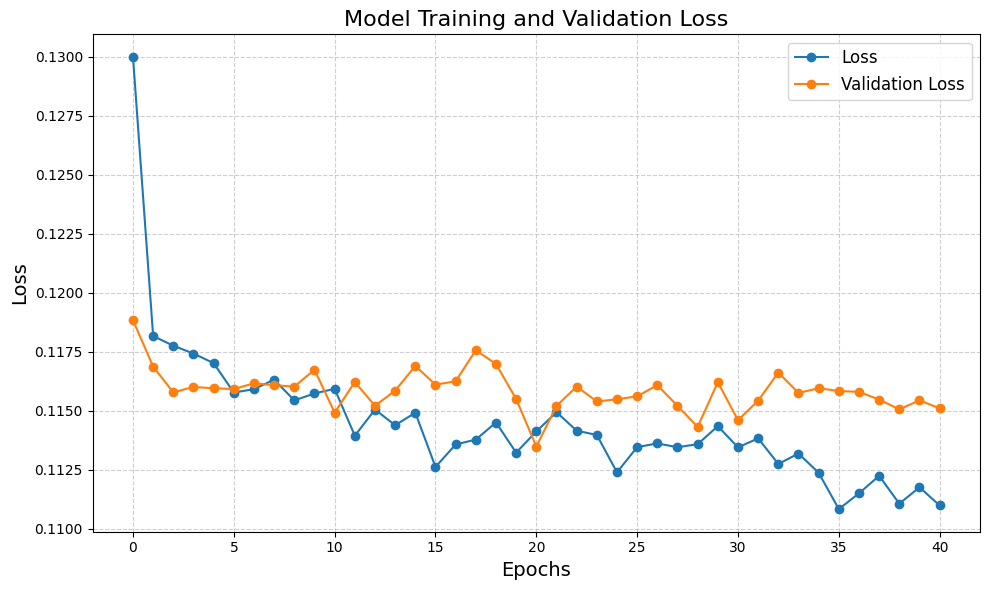

In [194]:
import matplotlib.pyplot as plt

# Graficar el desempeño de la red
plt.figure(figsize=(10, 6))

# Pérdida del entrenamiento
plt.plot(history.history['loss'], label='Loss', marker='o')

# Pérdida de validación (si está disponible)
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')

# Configuración de la gráfica
plt.title('Model Training and Validation Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()

# Mostrar gráfica
plt.show()

In [195]:
# Reconstrucción de la matriz de interacción
reconstructed_matrix = autoencoder.predict(interaction_array_norm)

# Crear un DataFrame para las calificaciones reconstruidas
reconstructed_df = pd.DataFrame(
    reconstructed_matrix,
    columns=business)

reconstructed_df.head()

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


,Asx28DdgUx6vYWSxl0oOAQ,XRodxenm9sHoYbD15Em4nQ,C2nzoqU60AcRPHpCBsEScQ,84HvpQDxcHWmbMDfs8IEYw,5G2IF0VIN3Brl-m45QDXsA,lAjldaKYbyAJDTXq8gmOTg,RCZ5M9o2-fxgFuurpmEs3w,oLjseICFHuisZmxrm6bqxA,onQsolCnpHwtOZCIuI91vQ,z9uf9-0uX5Jh8-4Y5l2PQg,...,GG0mFsEXb-02_dzFPqRV1Q,lMY8NBPyzlPbbu-KBYfD9A,vffKQc_WQMYFGY4JS5VAOw,njZ4R3YDG8QQC84joarNHg,RkOdQL51_KAkxlGbIUIXIA,cIVmIJD7nIiEcVGamfBoVw,4e9-roUfqfa7fp3zdMKDvw,D8CF2H3DYtNJlzR0IITMHQ,XBeEmeV16yfP9EXLiqkRhQ,UqTvUrtM9VZfcnjMyvfZxA
0,0.610064,0.695632,0.644532,0.330563,0.577491,0.436193,0.566463,0.713509,0.578262,0.554361,...,0.359862,0.698433,0.496840,0.517450,0.457344,0.491348,0.763315,0.196643,0.553525,0.389990
1,0.572407,0.598053,0.615539,0.324230,0.572656,0.424278,0.546472,0.693049,0.508138,0.499823,...,0.305322,0.686562,0.461548,0.498294,0.387310,0.447718,0.720383,0.178963,0.505805,0.370337
2,0.586683,0.622623,0.620296,0.322335,0.573963,0.429930,0.560820,0.703783,0.527683,0.515452,...,0.310913,0.692931,0.474695,0.505714,0.412537,0.457239,0.732364,0.180822,0.524304,0.373134
3,0.560304,0.590539,0.615064,0.330188,0.570895,0.419867,0.535507,0.683622,0.500468,0.493658,...,0.306049,0.682546,0.454060,0.494210,0.373798,0.446229,0.712873,0.183171,0.496639,0.371292
4,0.589603,0.651204,0.619169,0.331591,0.571806,0.440809,0.558482,0.695162,0.550596,0.534269,...,0.347291,0.680031,0.487388,0.509273,0.432598,0.473775,0.730905,0.212199,0.531164,0.387590


In [196]:

# Renombrar el índice para evitar conflictos con columnas existentes
reconstructed_df.index.name = "original_business_id"

# Reiniciar el índice sin conflictos
reconstructed_df = reconstructed_df.reset_index()
reconstructed_df = reconstructed_df.rename(columns={"original_business_id" :  "user_id"})


interaction_matrix = ratings_df_filtered.pivot(index='business_id', columns='user_id', values='stars').reset_index()
reconstructed_df['user_id'] = interaction_matrix.business_id

# Mostrar las primeras filas del DataFrame reconstruido
reconstructed_df.head()


,user_id,Asx28DdgUx6vYWSxl0oOAQ,XRodxenm9sHoYbD15Em4nQ,C2nzoqU60AcRPHpCBsEScQ,84HvpQDxcHWmbMDfs8IEYw,5G2IF0VIN3Brl-m45QDXsA,lAjldaKYbyAJDTXq8gmOTg,RCZ5M9o2-fxgFuurpmEs3w,oLjseICFHuisZmxrm6bqxA,onQsolCnpHwtOZCIuI91vQ,...,GG0mFsEXb-02_dzFPqRV1Q,lMY8NBPyzlPbbu-KBYfD9A,vffKQc_WQMYFGY4JS5VAOw,njZ4R3YDG8QQC84joarNHg,RkOdQL51_KAkxlGbIUIXIA,cIVmIJD7nIiEcVGamfBoVw,4e9-roUfqfa7fp3zdMKDvw,D8CF2H3DYtNJlzR0IITMHQ,XBeEmeV16yfP9EXLiqkRhQ,UqTvUrtM9VZfcnjMyvfZxA
0,-0TffRSXXIlBYVbb5AwfTg,0.610064,0.695632,0.644532,0.330563,0.577491,0.436193,0.566463,0.713509,0.578262,...,0.359862,0.698433,0.496840,0.517450,0.457344,0.491348,0.763315,0.196643,0.553525,0.389990
1,-1B9pP_CrRBJYPICE5WbRA,0.572407,0.598053,0.615539,0.324230,0.572656,0.424278,0.546472,0.693049,0.508138,...,0.305322,0.686562,0.461548,0.498294,0.387310,0.447718,0.720383,0.178963,0.505805,0.370337
2,-1XSzguS6XLN-V6MVZMg2A,0.586683,0.622623,0.620296,0.322335,0.573963,0.429930,0.560820,0.703783,0.527683,...,0.310913,0.692931,0.474695,0.505714,0.412537,0.457239,0.732364,0.180822,0.524304,0.373134
3,-6JdVK-DHB4_43PEksbg1A,0.560304,0.590539,0.615064,0.330188,0.570895,0.419867,0.535507,0.683622,0.500468,...,0.306049,0.682546,0.454060,0.494210,0.373798,0.446229,0.712873,0.183171,0.496639,0.371292
4,-9NmUeTphyS9Lq1o9MACGw,0.589603,0.651204,0.619169,0.331591,0.571806,0.440809,0.558482,0.695162,0.550596,...,0.347291,0.680031,0.487388,0.509273,0.432598,0.473775,0.730905,0.212199,0.531164,0.387590


In [197]:
# Convertir el DataFrame a formato largo
original_format_df = reconstructed_df.melt(
    id_vars="user_id",       # Columna que permanece como identificador
    var_name="business_id",          # Nombre de la columna de variables
    value_name="predicted_stars" # Nombre de la columna de valores
)

original_format_df.head()

,user_id,business_id,predicted_stars
0,-0TffRSXXIlBYVbb5AwfTg,Asx28DdgUx6vYWSxl0oOAQ,0.610064
1,-1B9pP_CrRBJYPICE5WbRA,Asx28DdgUx6vYWSxl0oOAQ,0.572407
2,-1XSzguS6XLN-V6MVZMg2A,Asx28DdgUx6vYWSxl0oOAQ,0.586683
3,-6JdVK-DHB4_43PEksbg1A,Asx28DdgUx6vYWSxl0oOAQ,0.560304
4,-9NmUeTphyS9Lq1o9MACGw,Asx28DdgUx6vYWSxl0oOAQ,0.589603


In [198]:
# Crear la columna de recomendación
original_format_df['rank'] = original_format_df.groupby('user_id')['predicted_stars'].rank(method='first', ascending=False)

# Generar la columna 'recommendation' indicando si la canción está entre las 20 mejores predicciones
original_format_df['recommendation'] = original_format_df['rank'] <= 20  # True si está en el top 10, False en caso contrario

In [199]:
recommendations = original_format_df[original_format_df.recommendation == True].sort_values(['user_id', 'rank'])
recommendations.head(20)

,user_id,business_id,predicted_stars,rank,recommendation
282744,-0TffRSXXIlBYVbb5AwfTg,xSlBsTTPtPvwlclBIvAjYw,0.921442,1.0,True
399840,-0TffRSXXIlBYVbb5AwfTg,ygQxFoytqvt6W0E2NQPJow,0.918178,2.0,True
632604,-0TffRSXXIlBYVbb5AwfTg,lmiiFd9KC15fs4xtEoXRvw,0.905539,3.0,True
574056,-0TffRSXXIlBYVbb5AwfTg,3iJlR7ZD69pf6be34lDpxg,0.845349,4.0,True
202776,-0TffRSXXIlBYVbb5AwfTg,2mehWDiaP-8CcZRtLGlYIA,0.842664,5.0,True
529788,-0TffRSXXIlBYVbb5AwfTg,Y4ZmJCuAbIvnv45oIIuLHA,0.833782,6.0,True
464100,-0TffRSXXIlBYVbb5AwfTg,p-3grx8aw9eowG36jkouWA,0.824228,7.0,True
342720,-0TffRSXXIlBYVbb5AwfTg,e4t4Phko2POKIMW4XoKX7A,0.823755,8.0,True
148512,-0TffRSXXIlBYVbb5AwfTg,UrQw8IyTOAAlokN-SMK3_Q,0.823715,9.0,True
84252,-0TffRSXXIlBYVbb5AwfTg,tuoDDqTDCB-lDgelvMrp5Q,0.822564,10.0,True


### **Diversidad de las recomendaciones**

La diversidad de recomendación mide qué tan variadas son las recomendaciones para los usuarios en relación con el catálogo de productos.

In [200]:
len(recommendations.business_id.drop_duplicates())

36

In [201]:
len(original_format_df.business_id.drop_duplicates())

526

In [202]:
len(recommendations.business_id.drop_duplicates())/len(original_format_df.business_id.drop_duplicates())

0.06844106463878327

Un valor del 60% indica que tus recomendaciones cubren el 60% del catálogo total.

**Diversidad baja (<30%):**
Los productos recomendados se concentran en una pequeña parte del catálogo.
Beneficia a productos populares pero puede ignorar nichos y reducir la personalización.

**Diversidad alta (>80%):**
Aumenta la visibilidad del catálogo completo.
Puede comprometer la relevancia de las recomendaciones al incluir productos con poca afinidad con los usuarios.

Recomendar el 60% del catálogo es positivo porque evita el "sesgo de concentración", donde solo unos pocos productos dominan las recomendaciones.
Esto permite que más productos sean visibles para los usuarios.

### **Conclusión**

En este laboratorio, implementamos un sistema de recomendación basado en autoencoders. El modelo es capaz de comprimir y reconstruir información de la matriz de interacción, destacando su utilidad en sistemas con alta dimensionalidad. Ajustes adicionales podrían incluir la optimización de hiperparámetros o el uso de regularización para mejorar el desempeño.

---
## Gracias por completar este laboratorio!